
For a Gaussian distribution, the probability density function (pdf) is given by:

$ p(\mathbf{x} | \mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right) $

where:
- $\mathbf{x}$ is the data point in $d$-dimensional space,
- $\mathbf{\mu}$ is the mean vector,
- $\Sigma$ is the covariance matrix,
- $|\Sigma|$ is the determinant of $\Sigma$,
- $\Sigma^{-1}$ is the inverse of $\Sigma$.

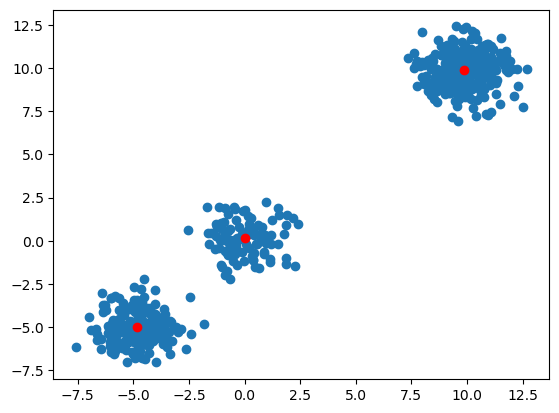

Means:
[[-1.24446424e-03  1.42390728e-01]
 [ 9.88066740e+00  9.87597491e+00]
 [-4.85589266e+00 -4.98042222e+00]]
Weights:
[0.16668579 0.5        0.33331421]
Covariances:
[[[ 1.04500003e+00 -2.39522563e-02]
  [-2.39522563e-02  1.03307755e+00]]

 [[ 9.51187977e-01 -7.94561716e-04]
  [-7.94561716e-04  9.82446210e-01]]

 [[ 8.74718405e-01  2.73310089e-03]
  [ 2.73310089e-03  8.53027174e-01]]]


In [5]:
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt

# Initialize Gaussian Mixture Model with 3 components
g = mixture.GaussianMixture(n_components=3)
np.random.seed(0)

# Generate observations from 3 distributions
obs = np.concatenate((np.random.randn(100, 2), 10 + np.random.randn(300, 2), -5 + np.random.randn(200, 2)))

# Fit the model
g.fit(obs)

# Scatter plot of observations
plt.scatter(obs[:, 0], obs[:, 1])

# Scatter plot of the means of the Gaussian components
plt.scatter(g.means_[:, 0], g.means_[:, 1], color='red')

plt.show()

# Print model parameters
print("Means:")
print(g.means_)
print("Weights:")
print(g.weights_)
print("Covariances:")
print(g.covariances_)


# Analytic distance metric for Gaussian mixture models

$\begin{equation}
D_{\text{KL}}(p \parallel q) = \int_{-\infty}^{\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx
\end{equation}$

$
\label{analytical_Kullback_Liebler_divergence}
C_2(p \parallel q) = -\log \left( \frac{2\sum_{i,j} \pi_{i} \pi_{j}^{\prime} \sqrt{ \frac{|V_{ij}|}{e^{k_{ij}}|\Sigma_{i}| |\Sigma_{j}^{\prime}|} }}{\sum_{i,j} \pi_{i}\pi_{j} \sqrt{ \frac{|V_{ij}|}{e^{k_{ij}}|\Sigma_{i}| |\Sigma_{j}|}} + \sum_{i,j} \pi_{i}^{\prime}\pi_{j}^{\prime} \sqrt{ \frac{|V_{ij}|}{e^{k_{ij}}|\Sigma_{i}^{\prime}| |\Sigma_{j}^{\prime}|} }} \right)
$


$\label{Kullback_Liebler_divergence_Details1}
V_{ij} = (\Sigma_i^{-1} + \Sigma_j^{-1})^{-1}$

$\label{Kullback_Liebler_divergenceDetails2}
K_{ij} = \mu_i^T \Sigma_i^{-1} (\mu_i - \mu_j^{\prime}) + \mu_j^{\prime T} \Sigma_j^{\prime -1} (\mu_j^{\prime} - \mu_i)$


In [23]:
import numpy as np

def GetDistanceBetweenTwoDists(means1, pis1, covs1, means2, pis2, covs2):
    num_means1 = means1.shape[0]
    num_means2 = means2.shape[0]
    dim_covs = covs1.shape[1]

    # Initialize V and K matrices
    V11 = np.zeros((num_means1, num_means1))
    K11 = np.zeros((num_means1, num_means1))
    V12 = np.zeros((num_means1, num_means2))
    K12 = np.zeros((num_means1, num_means2))
    V22 = np.zeros((num_means2, num_means2))
    K22 = np.zeros((num_means2, num_means2))

    # Compute V11, K11
    for i in range(num_means1):
        for j in range(num_means1):
            cov1 = covs1[i].reshape(dim_covs, dim_covs)
            cov2 = covs1[j].reshape(dim_covs, dim_covs)
            inv_cov1 = np.linalg.inv(cov1)
            inv_cov2 = np.linalg.inv(cov2)
            V11[i, j] = np.linalg.det(np.linalg.inv(inv_cov1 + inv_cov2))
            K11[i, j] = means1[i] @ inv_cov1 @ (means1[i] - means1[j]).T + means1[j] @ inv_cov2 @ (means1[j] - means1[i]).T

    # Compute V12, K12
    for i in range(num_means1):
        for j in range(num_means2):
            cov1 = covs1[i].reshape(dim_covs, dim_covs)
            cov2 = covs2[j].reshape(dim_covs, dim_covs)
            V12[i, j] = np.linalg.det(np.linalg.inv(np.linalg.inv(cov1) + np.linalg.inv(cov2)))
            K12[i, j] = means1[i] @ np.linalg.inv(cov1) @ (means1[i] - means2[j]).T + means2[j] @ np.linalg.inv(cov2) @ (means2[j] - means1[i]).T

    # Compute V22, K22
    for i in range(num_means2):
        for j in range(num_means2):
            cov1 = covs2[i].reshape(dim_covs, dim_covs)
            cov2 = covs2[j].reshape(dim_covs, dim_covs)
            V22[i, j] = np.linalg.det(np.linalg.inv(np.linalg.inv(cov1) + np.linalg.inv(cov2)))
            K22[i, j] = means2[i] @ np.linalg.inv(cov1) @ (means2[i] - means2[j]).T + means2[j] @ np.linalg.inv(cov2) @ (means2[j] - means2[i]).T

    # Compute Sums
    Sum11 = Sum12 = Sum22 = 0.0
    for i in range(num_means1):
        for j in range(num_means1):
            cov1 = covs1[i].reshape(dim_covs, dim_covs)
            cov2 = covs1[j].reshape(dim_covs, dim_covs)
            Sum11 += pis1[i] * pis1[j] * np.sqrt(V11[i, j] / (np.exp(K11[i, j]) * np.linalg.det(cov1) * np.linalg.det(cov2)))

    for i in range(num_means1):
        for j in range(num_means2):
            cov1 = covs1[i].reshape(dim_covs, dim_covs)
            cov2 = covs2[j].reshape(dim_covs, dim_covs)
            Sum12 += pis1[i] * pis2[j] * np.sqrt(V12[i, j] / (np.exp(K12[i, j]) * np.linalg.det(cov1) * np.linalg.det(cov2)))

    for i in range(num_means2):
        for j in range(num_means2):
            cov1 = covs2[i].reshape(dim_covs, dim_covs)
            cov2 = covs2[j].reshape(dim_covs, dim_covs)
            Sum22 += pis2[i] * pis2[j] * np.sqrt(V22[i, j] / (np.exp(K22[i, j]) * np.linalg.det(cov1) * np.linalg.det(cov2)))

    distance = -np.log(2 * Sum12 / (Sum11 + Sum22))

    return distance






9.0

In [24]:
# Simple test for the GetDistanceBetweenTwoDists function

# Defining two simple Gaussian distributions
means1 = np.array([[0, 0]])
pis1 = np.array([1])
covs1 = np.array([[[1, 0], [0, 1]]])

means2 = np.array([[3, 3]])
pis2 = np.array([1])
covs2 = np.array([[[1, 0], [0, 1]]])

# Calling the distance function
simple_distance = GetDistanceBetweenTwoDists(means1, pis1, covs1, means2, pis2, covs2)

simple_distance


9.0

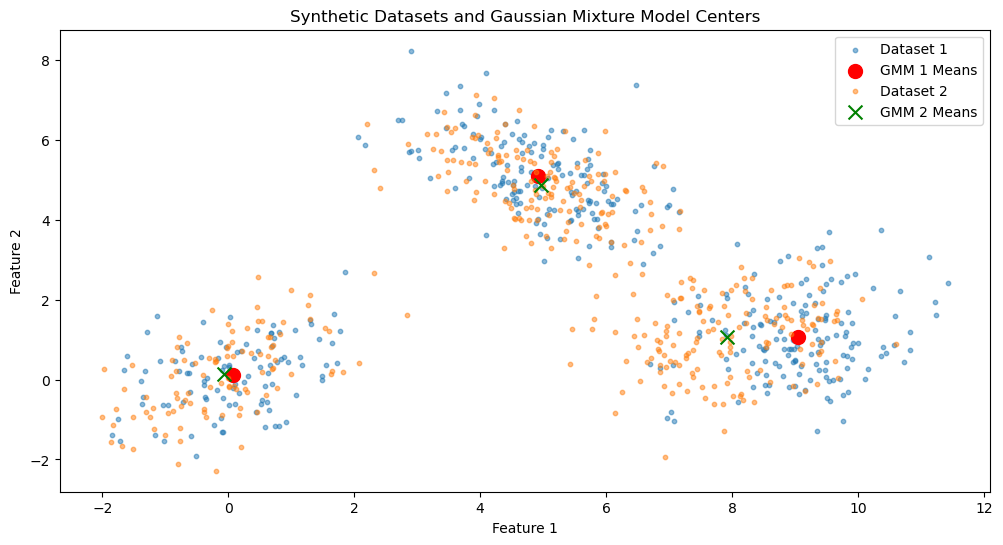

0.3513695014896637

In [26]:
from sklearn import mixture

# Initialize Gaussian Mixture Model with 3 components
g = mixture.GaussianMixture(n_components=3)

# Generate synthetic data for testing
np.random.seed(42)  # For reproducibility
test_data = np.concatenate([
    np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 100),
    np.random.multivariate_normal([5, 5], [[1, -0.5], [-0.5, 1]], 150),
    np.random.multivariate_normal([9, 1], [[1, 0.2], [0.2, 1]], 150)
])

# Fit the Gaussian Mixture Model to the synthetic data
g.fit(test_data)

# Assume another Gaussian Mixture Model with slightly different parameters as the second distribution
np.random.seed(24)  # Change the seed for different data
test_data2 = np.concatenate([
    np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 100),
    np.random.multivariate_normal([5, 5], [[1, -0.5], [-0.5, 1]], 150),
    np.random.multivariate_normal([8, 1], [[1, 0.2], [0.2, 1]], 150)
])
g2 = mixture.GaussianMixture(n_components=3)
g2.fit(test_data2)



# Plotting the synthetic data and the centers of the Gaussian components from both GMMs

plt.figure(figsize=(12, 6))

# Plotting the first synthetic dataset
plt.scatter(test_data[:, 0], test_data[:, 1], s=10, alpha=0.5, label='Dataset 1')
plt.scatter(g.means_[:, 0], g.means_[:, 1], s=100, marker='o', color='red', label='GMM 1 Means')

# Plotting the second synthetic dataset
plt.scatter(test_data2[:, 0], test_data2[:, 1], s=10, alpha=0.5, label='Dataset 2')
plt.scatter(g2.means_[:, 0], g2.means_[:, 1], s=100, marker='x', color='green', label='GMM 2 Means')

plt.title('Synthetic Datasets and Gaussian Mixture Model Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()



# Use the fitted parameters to test GetDistanceBetweenTwoDists
distance = GetDistanceBetweenTwoDists(g.means_, g.weights_, g.covariances_, g2.means_, g2.weights_, g2.covariances_)
distance
